In [1]:
from unet_model import UNet
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

from seep_dataset import SeepImageDataset
from torch.utils.data import DataLoader, random_split
from utils import ImageHelperFunctions, ImageTransformFunctions

In [2]:
IMAGE_DIR = "./seep_detection/images_256/"
MASK_DIR = "./seep_detection/masks_256/"
BATCH_SIZE = 8

transform = ImageTransformFunctions()
helper = ImageHelperFunctions()

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
model = UNet(1, 8).to(device)
model.load_state_dict(torch.load("./models/FocalLoss_milesialUnet_[1, 20, 40, 40, 40, 20, 20, 80]_p=300_no_val_lr=0.01"))

<All keys matched successfully>

In [4]:
dataset = SeepImageDataset(IMAGE_DIR, MASK_DIR)
#n_val = int(np.floor(0.1 * len(dataset)))
n_test = int(np.floor(0.1 * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

In [5]:
train_loader = DataLoader(
    dataset = train_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)


mu, std = helper.find_mu_and_std(test_loader)

mu = mu.numpy()
std = std.numpy()

print(mu, std)

[0.01931201] [1.0305812]


In [6]:
images, masks = next(iter(train_loader))

images = images.to(device)
masks = masks.to(device)
model.eval()
with torch.no_grad():
    test_preds = model(images)
    
print(masks.shape, images.shape, test_preds.shape)

torch.Size([8, 256, 256]) torch.Size([8, 1, 256, 256]) torch.Size([8, 8, 256, 256])


In [7]:
images = images.cpu().numpy()
masks = masks.cpu().numpy()
test_preds = test_preds.cpu().numpy()

classes: [0 1]
counts: [64364  1172]
mask: (array([0, 1], dtype=uint8), array([64364,  1172], dtype=int64))
classes: [0 1]
counts: [63882  1654]
pred: (array([0, 1], dtype=uint8), array([63882,  1654], dtype=int64))


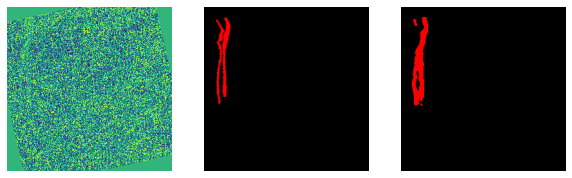

classes: [0 6]
counts: [65389   147]
mask: (array([0, 6], dtype=uint8), array([65389,   147], dtype=int64))
classes: [0]
counts: [65536]
pred: (array([0], dtype=uint8), array([65536], dtype=int64))


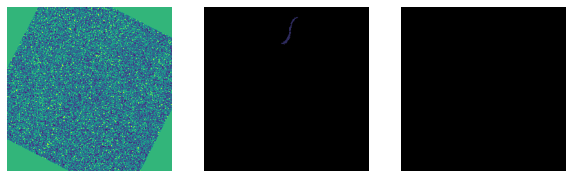

classes: [0 1 6]
counts: [61624  3270   642]
mask: (array([0, 1, 6], dtype=uint8), array([61624,  3270,   642], dtype=int64))
classes: [0 1]
counts: [59979  5557]
pred: (array([0, 1], dtype=uint8), array([59979,  5557], dtype=int64))


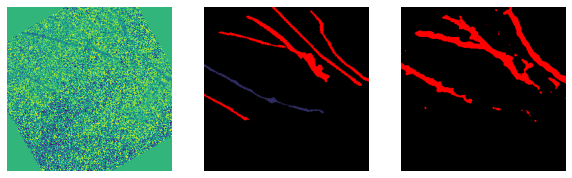

classes: [0 1 3]
counts: [64940    91   505]
mask: (array([0, 1, 3], dtype=uint8), array([64940,    91,   505], dtype=int64))
classes: [0 1]
counts: [65445    91]
pred: (array([0, 1], dtype=uint8), array([65445,    91], dtype=int64))


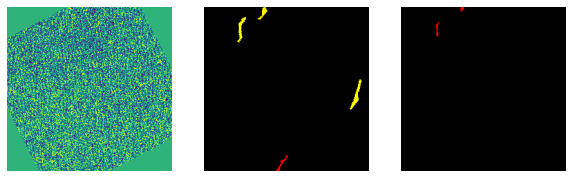

classes: [0 1]
counts: [65201   335]
mask: (array([0, 1], dtype=uint8), array([65201,   335], dtype=int64))
classes: [0 4 5]
counts: [63996   232  1308]
pred: (array([0, 4, 5], dtype=uint8), array([63996,   232,  1308], dtype=int64))


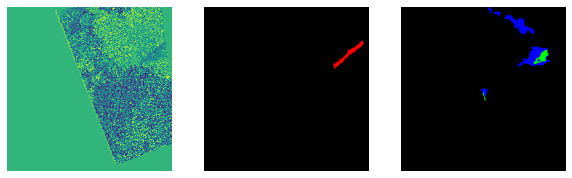

classes: [0 1]
counts: [64205  1331]
mask: (array([0, 1], dtype=uint8), array([64205,  1331], dtype=int64))
classes: [0 1]
counts: [63904  1632]
pred: (array([0, 1], dtype=uint8), array([63904,  1632], dtype=int64))


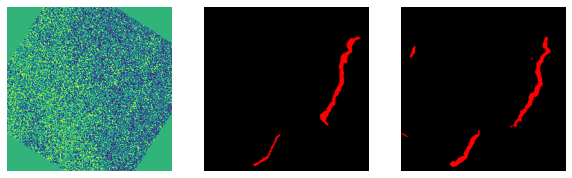

classes: [0 1]
counts: [65433   103]
mask: (array([0, 1], dtype=uint8), array([65433,   103], dtype=int64))
classes: [0 1]
counts: [65474    62]
pred: (array([0, 1], dtype=uint8), array([65474,    62], dtype=int64))


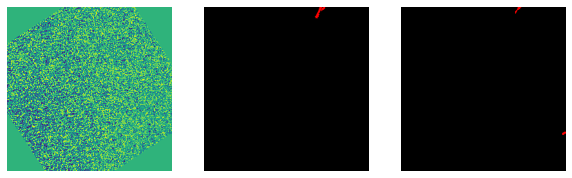

classes: [0 1 6]
counts: [64428   604   504]
mask: (array([0, 1, 6], dtype=uint8), array([64428,   604,   504], dtype=int64))
classes: [0 1]
counts: [62086  3450]
pred: (array([0, 1], dtype=uint8), array([62086,  3450], dtype=int64))


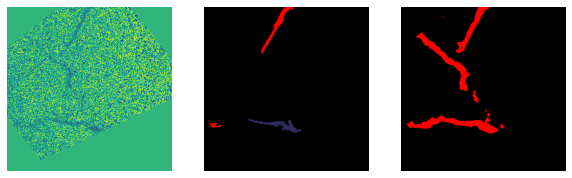

In [8]:
for i in range(images.shape[0]):
    image = images[i, :, :]
    mask = masks[i, :, :]
    pred = test_preds[i, :, :, :]
    
    image = transform.inv_normalize(image, mu, std)
    
    mask = mask.astype(np.uint8)
    mask = Image.fromarray(mask, 'L')
    print(f"mask: {helper.count_classes_in_arr(mask)}") 
    mask = transform.mask_to_palette(mask)
    
    pred = np.where(pred > 0.5,1,0)
    pred = transform.onehot_to_mask(pred)
    print(f"pred: {helper.count_classes_in_arr(pred)}")
    pred = transform.mask_to_palette(pred)
    
    helper.preview_images((image, mask, pred))
    